# IMPORTS

In [1]:
%matplotlib notebook
from utils.setup import *

# LOAD DATA

In [2]:
train = pd.read_csv('train_prophet.csv', index_col=0)
train['ds'] = train.index
test = pd.read_csv('test_prophet.csv', index_col=0)

In [3]:
train.drop('ds', axis=1, inplace=True)

In [4]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [5]:
test_ids = test['IDS'].copy()

In [6]:
train.drop(['IDS', 'Horodate_UTC'], axis=1, inplace=True)
test.drop(['IDS', 'Horodate_UTC'], axis=1, inplace=True)

# Features Creation

In [12]:
def features_creation(df, target):
        
    # Date Time Features
    ref_date = pd.to_datetime('2013-09-01 00:00')
    
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['time_passed'] = [(df.index[i]-ref_date).total_seconds() for i in range(len(df))]
    df['time_passed_scaled'] = df['time_passed'] / max(df['time_passed'])
    for i in range(24):
        df['hour_%s' % i] = (df.index.hour == i) * 1
    for i in range(1,13):
        df['month_%s' % i] = (df.index.month == i) * 1
    df['weekend'] = (df.index.weekday.isin([5, 6])) * 1
    
    return df

In [8]:
FEAT_DICT = dict.fromkeys(TARGETS)
FEAT_DICT['RES1_BASE'] = ['Consommation totale profilée (W)']
FEAT_DICT['RES11_BASE'] = ['Consommation totale profilée (W)']
FEAT_DICT['RES2_HC'] = ['Production décentralisée profilée (W)']
FEAT_DICT['RES2_HP'] = ['Pertes modélisées (W)']
FEAT_DICT['PRO1_BASE'] = ['Consommation PME-PMI profilée (W)']
FEAT_DICT['PRO2_HC'] = ['Production décentralisée profilée (W)']
FEAT_DICT['PRO2_HP'] = ['Consommation PME-PMI profilée (W)']

for key in list(FEAT_DICT.keys()):
    to_add = ['Température réalisée lissée (°Celcius)'] + ['hour_%s' % i for i in range(24)] + ['month_%s' % i for i in range(1,13)]
    FEAT_DICT[key] += to_add

In [9]:
# hour_mean = dict.fromkeys(TARGETS)

# for tar in TARGETS:
#     hour_mean[tar] = dict(train.groupby('hour').mean()[tar])

# def get_mean_hour(hour):
#     return hour_mean['PRO1_BASE'][hour]

# Quick RFR

In [30]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle

def rfr_prediction(df, target, test, save_model=False, filename='model'):
    
        
    feat = FEAT_DICT[target].copy()
    
    df = features_creation(train, target)
    df = df[FEAT_DICT[target] + [target]]

    if target.startswith('P'):
        df.dropna(inplace=True)

    feat.append(target)

    df = df[feat]

    X = df.drop(target, axis=1)
    y = df[target]
    
    start_test = '2017-12'
    
    if save_model:
        start_test = None
    
    X_train, X_test, y_train, y_test = X[:start_test], X[start_test:], y[:start_test], y[start_test:]
    pipeline = make_pipeline(preprocessing.MinMaxScaler(),
                             RandomForestRegressor(n_jobs=-1,n_estimators=10, max_depth=None))
    hyperparameters = {
#                         'randomforestregressor__max_features':['auto','sqrt'],
#                        'randomforestregressor__max_depth':[10, 20, 50, 100, None],
#                        'randomforestregressor__min_samples_leaf': [1,2,4],
#                        'randomforestregressor__min_samples_split':[2,5,10]
    }
    clf = GridSearchCV(pipeline,hyperparameters, cv=10)
    clf.fit(X_train, y_train)
    clf = clf.best_estimator_
    clf.fit(X_train, y_train)
    pred_train = pd.Series(clf.predict(X_train).ravel(), index=X_train.index)
    pred_test = pd.Series(clf.predict(X_test).ravel(), index=X_test.index)
    
    print('{} prediction : \n'.format(target))
    print('RMSE train', mean_squared_error(y_train, pred_train)**0.5)
    print('RMSE test', mean_squared_error(y_test, pred_test)**0.5)    
    print ('R²_train', clf.score(X_train, y_train))    
    print ('R²_test', clf.score(X_test, y_test))
    plt.figure()
    plt.xlabel('Measured')
    plt.ylabel('Prediction')
    plt.scatter(y_train, pred_train, alpha=0.3, label='train')
    plt.scatter(y_test, pred_test, alpha=0.3, label='test')
    plt.show()
    
    plt.figure()
    plt.ylabel(target)
    plt.plot(y_train, label='truth train')
    plt.plot(pred_train, label='prediction train')
    plt.plot(y_test, label='truth test')
    plt.plot(pred_test, label='prediction test')
    plt.legend()
    plt.show()
    
    if save_model:
        with open('{}_model.p'.format(filename), 'wb') as file:
            pickle.dump(clf, file)
        print('Model Saved')
    
    return pd.DataFrame({'y_test':y_test, 'pred':pd.Series(pred_test)}, index=y.index)

RES1_BASE prediction : 

RMSE train 0.04088436640109616
RMSE test 0.04088436640109616
R²_train 0.9844246726290138
R²_test 0.9844246726290138


<IPython.core.display.Javascript object>


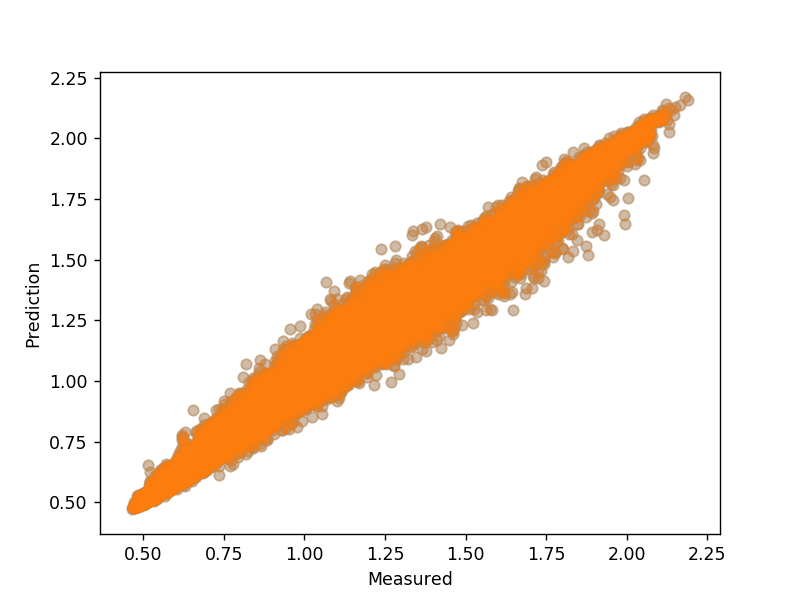

<IPython.core.display.Javascript object>


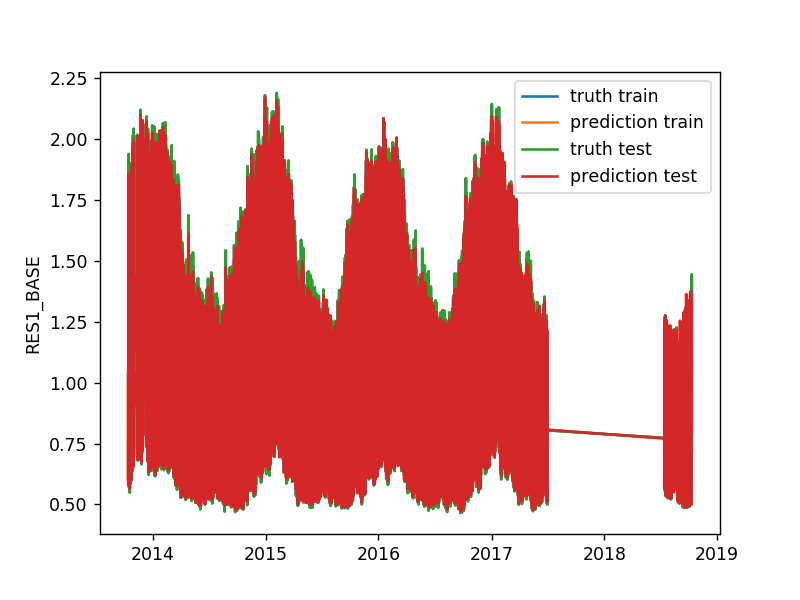

Model Saved
RES11_BASE prediction : 

RMSE train 0.04150869298783297
RMSE test 0.04150869298783297
R²_train 0.9875611289302858
R²_test 0.9871001641675723


<IPython.core.display.Javascript object>


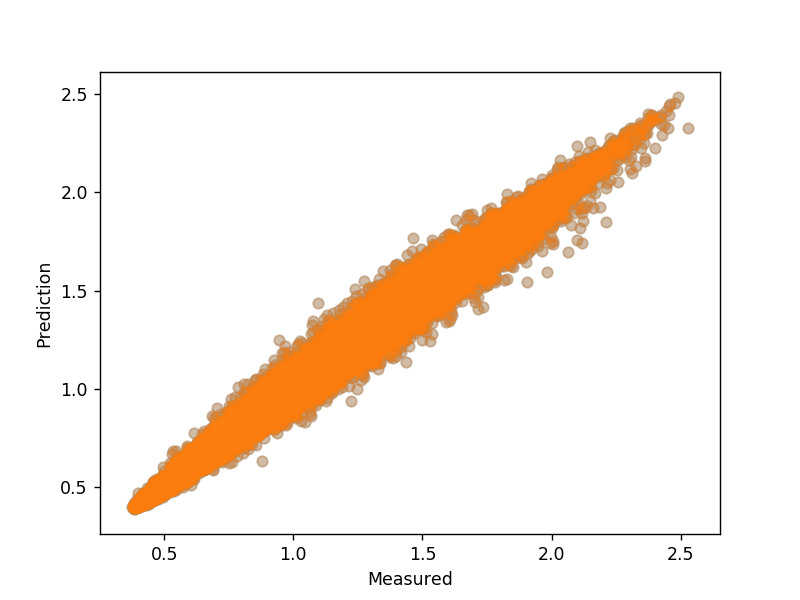

<IPython.core.display.Javascript object>


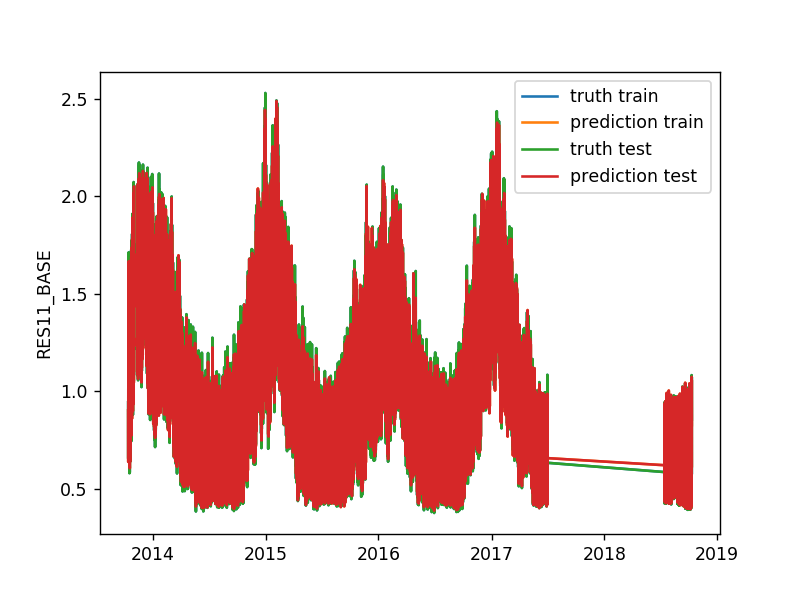

Model Saved
RES2_HC prediction : 

RMSE train 0.12017818381067921
RMSE test 0.12017818381067921
R²_train 0.9898054911965899
R²_test 0.9898054911965899


<IPython.core.display.Javascript object>


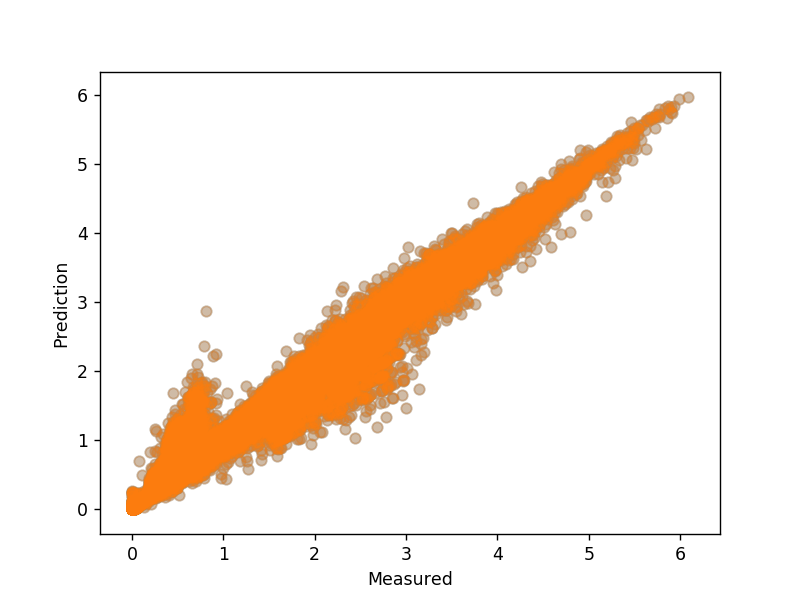

<IPython.core.display.Javascript object>


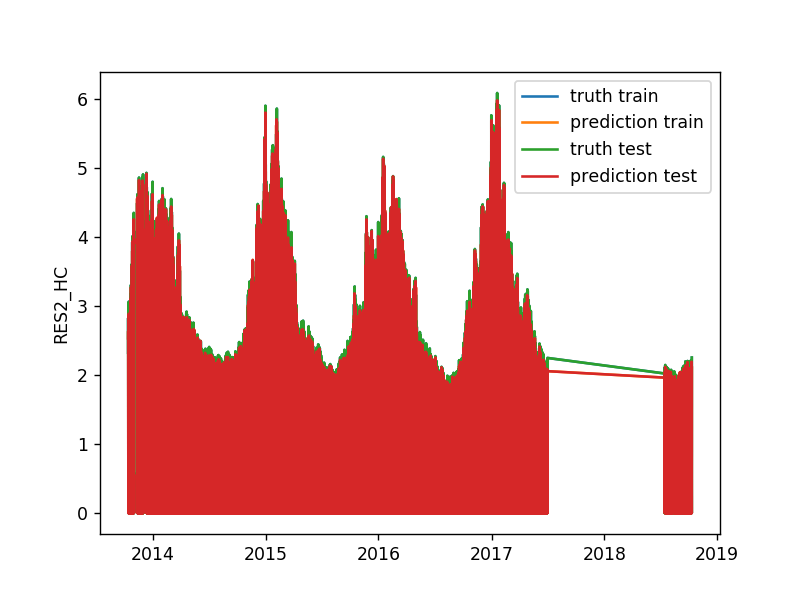

Model Saved
RES2_HP prediction : 

RMSE train 0.07039930183174832
RMSE test 0.07039930183174832
R²_train 0.9934862800236338
R²_test 0.9934862800236338


<IPython.core.display.Javascript object>


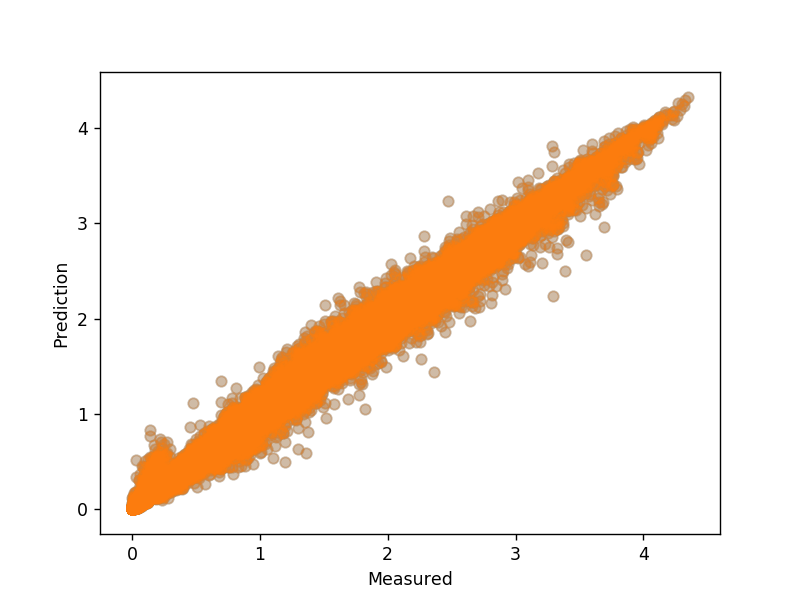

<IPython.core.display.Javascript object>


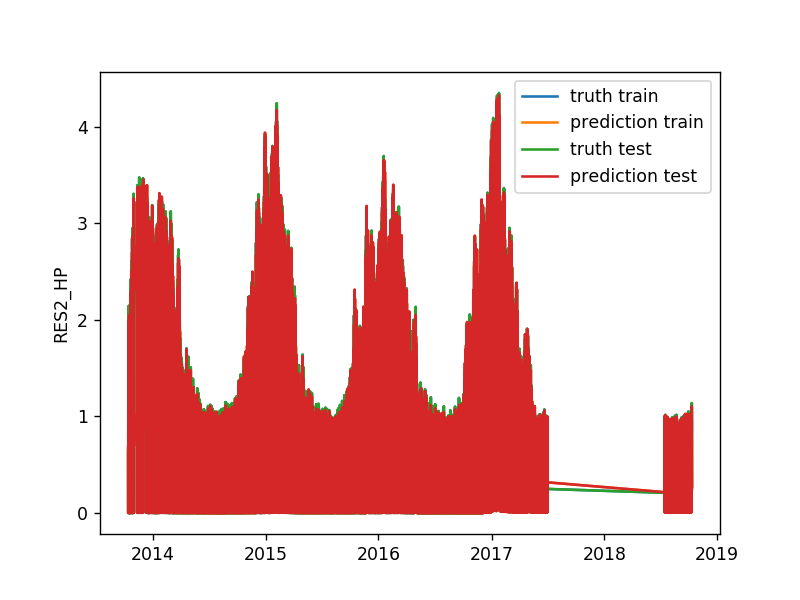

Model Saved


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRO1_BASE prediction : 

RMSE train 0.038955319324161006
RMSE test 0.038955319324161006
R²_train 0.9893888859683908
R²_test 0.9893888859683908


<IPython.core.display.Javascript object>


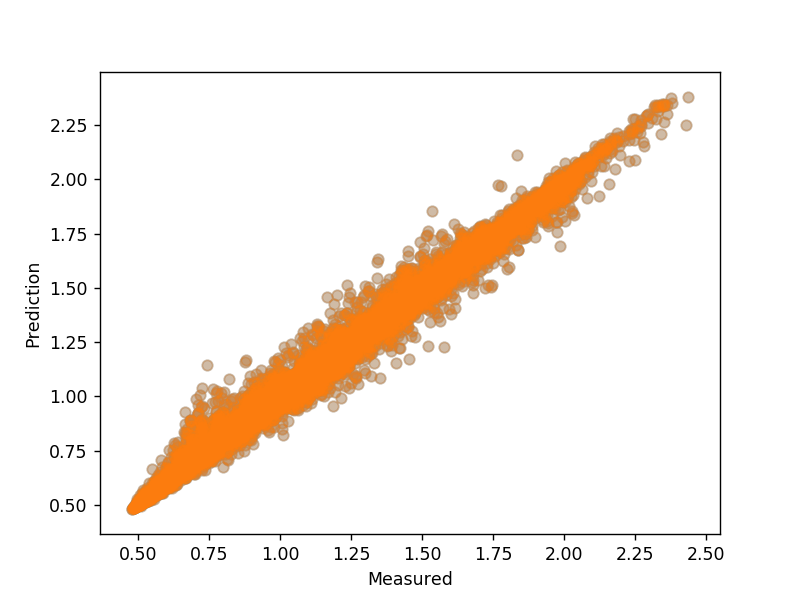

<IPython.core.display.Javascript object>


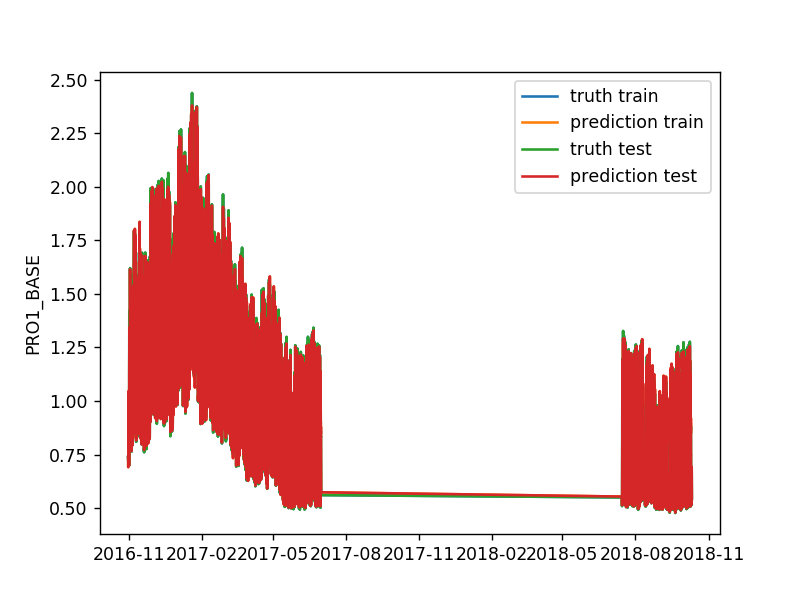

Model Saved


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRO2_HC prediction : 

RMSE train 0.08284852377883739
RMSE test 0.08284852377883739
R²_train 0.9946530471875548
R²_test 0.9946530471875548


<IPython.core.display.Javascript object>


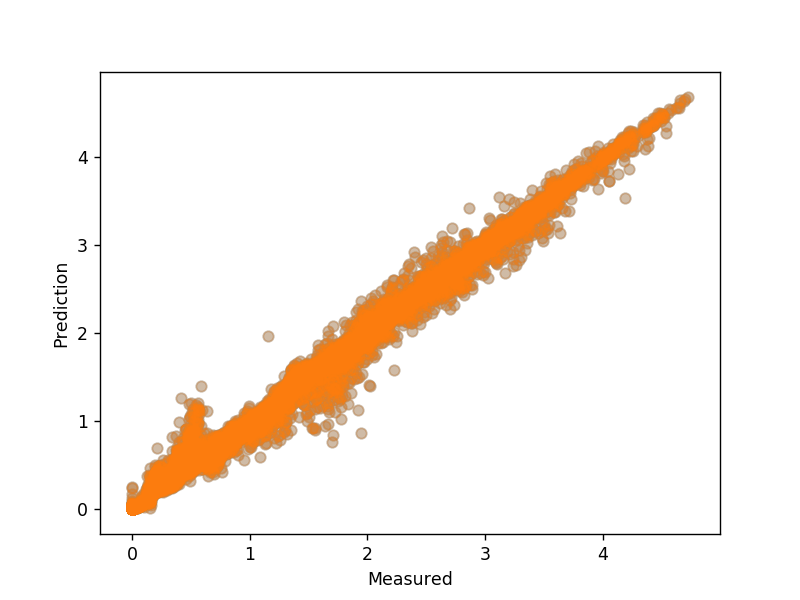

<IPython.core.display.Javascript object>


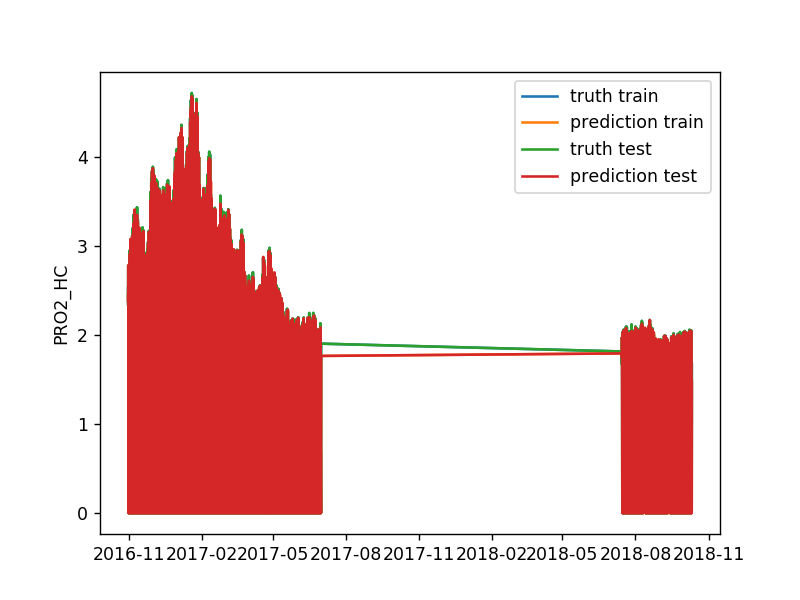

Model Saved


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRO2_HP prediction : 

RMSE train 0.0481467414265735
RMSE test 0.048146741426573506
R²_train 0.9953472095730008
R²_test 0.9953472095730008


<IPython.core.display.Javascript object>


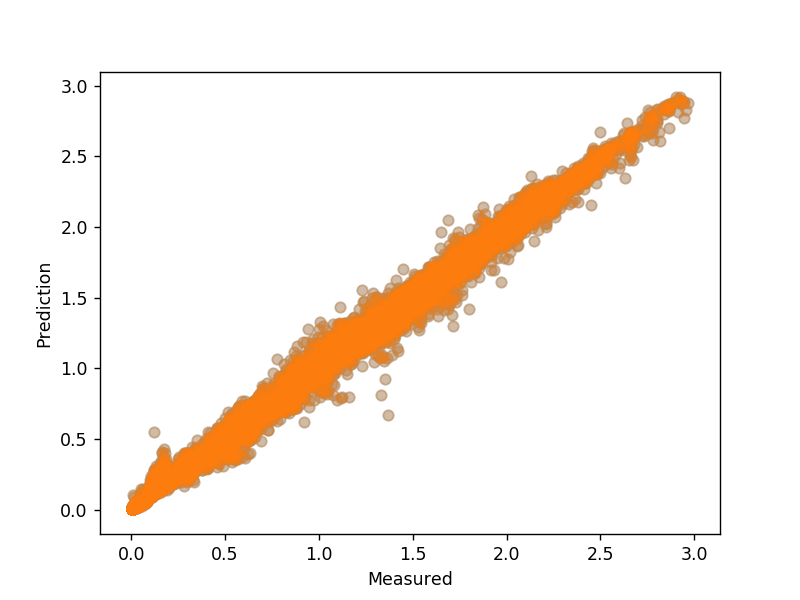

<IPython.core.display.Javascript object>


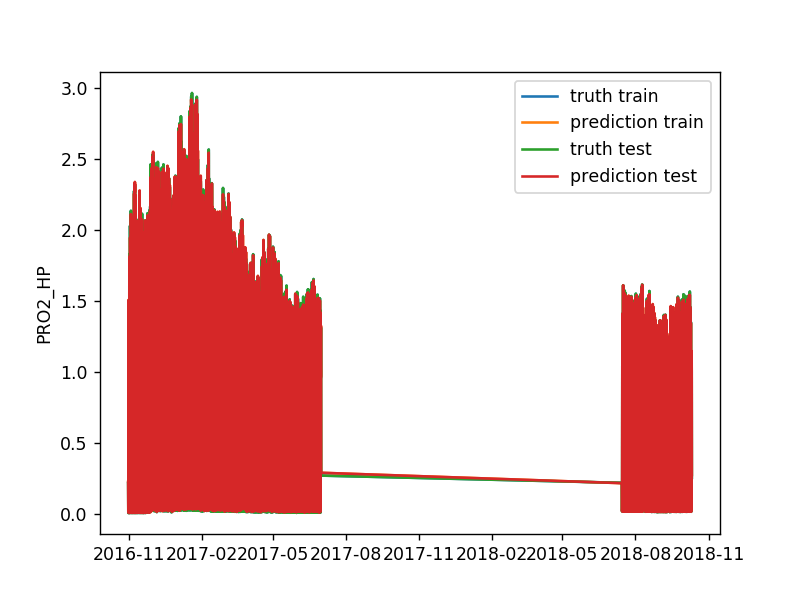

Model Saved


In [31]:
%matplotlib notebook
for tar in TARGETS:
    rfr_prediction(train, tar, True, True, tar)

# Hyperopt

In [15]:
from predictions.toolbox.hyperopt.hyperopt import scan_param, ranking
from predictions.config.hyperopt_model_config import regressor_config_dict

/usr/lib64/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
model_grid = {'n_estimators': range(1, 5, 5),
 'min_samples_split': range(2, 21, 5),
 'min_samples_leaf': range(1, 21, 5),
 'max_depth': range(5, 20, 2),
 'bootstrap': [True, False]}

In [18]:
TARGET = 'RES1_BASE'
features = FEAT_DICT[TARGET]
scan_hist = scan_param(model_name='random_forest',
                       model_grid=model_grid,
                       training_grid={},
                       frac=1,
                       X=train[features],
                       t=train[[TARGET]])  

Testing 256 out of 256 possible combinations.
Model Iteration #0 to #9
Model Iteration #10 to #19
Model Iteration #20 to #29
Model Iteration #30 to #39
Model Iteration #40 to #49
Model Iteration #50 to #59
Model Iteration #60 to #69
Model Iteration #70 to #79
Model Iteration #80 to #89
Model Iteration #90 to #99
Model Iteration #100 to #109
Model Iteration #110 to #119
Model Iteration #120 to #129
Model Iteration #130 to #139
Model Iteration #140 to #149
Model Iteration #150 to #159
Model Iteration #160 to #169
Model Iteration #170 to #179
Model Iteration #180 to #189
Model Iteration #190 to #199
Model Iteration #200 to #209
Model Iteration #210 to #219
Model Iteration #220 to #229
Model Iteration #230 to #239
Model Iteration #240 to #249
Model Iteration #250 to #259


<IPython.core.display.Javascript object>


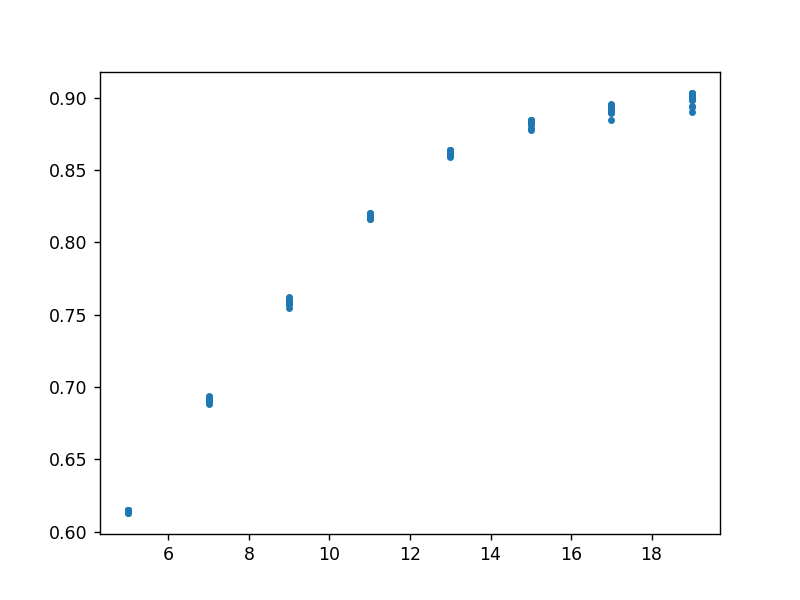

In [19]:
rank_df = ranking(scan_hist, ascending=True)['sklearn.ensemble.RandomForestRegressor']
plt.figure()
plt.plot(rank_df['max_depth'], rank_df['perf'], '.')

In [22]:
best_conf = rank_df.iloc[-1, :]['model_configs']
best_conf

{'bootstrap': False,
 'max_depth': 19,
 'min_samples_leaf': 16,
 'min_samples_split': 7,
 'n_estimators': 1}

RES1_BASE prediction : 

RMSE train 0.09794232553858123
RMSE test 0.08613162827886267
R²_train 0.9122633965548971
R²_test 0.8326117847420768


<IPython.core.display.Javascript object>


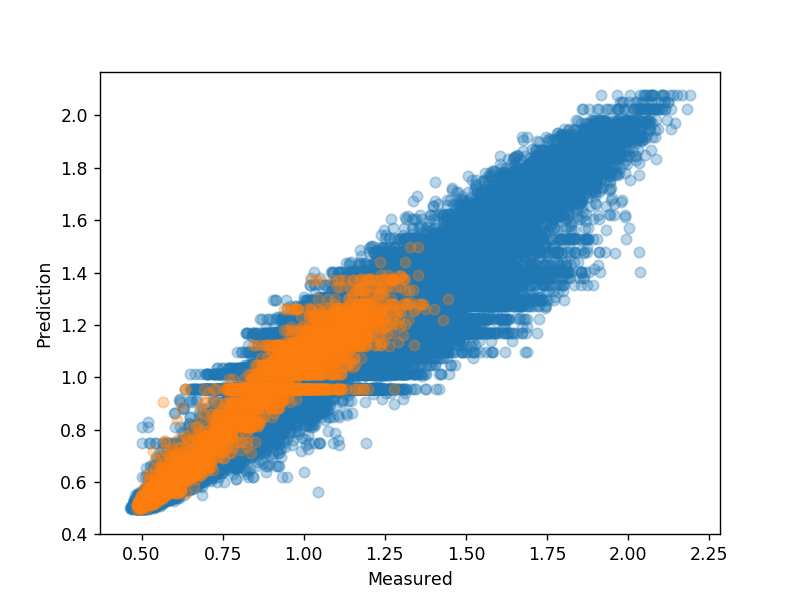

<IPython.core.display.Javascript object>


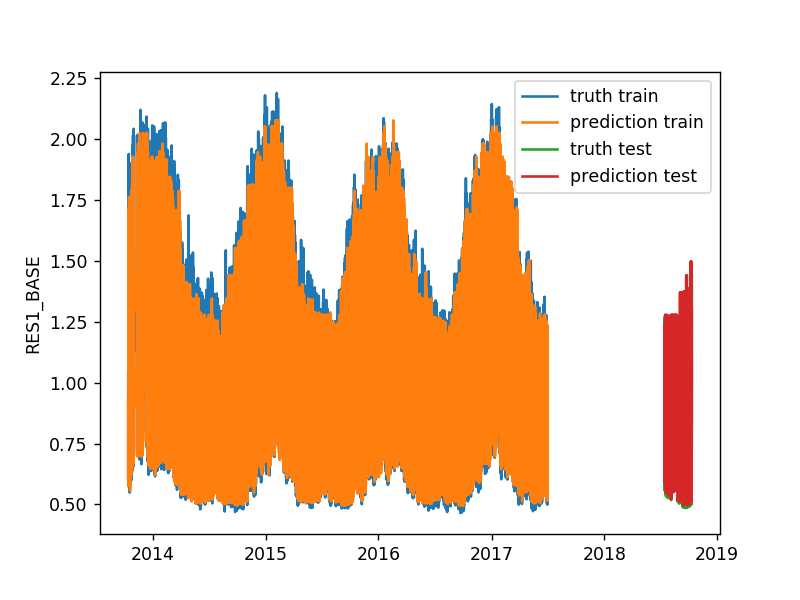

Model Saved


,pred,y_test
2013-10-13 00:00:00,NaN,NaN
2013-10-13 00:30:00,NaN,NaN
2013-10-13 01:00:00,NaN,NaN
2013-10-13 01:30:00,NaN,NaN
2013-10-13 02:00:00,NaN,NaN
2013-10-13 02:30:00,NaN,NaN
2013-10-13 03:00:00,NaN,NaN
2013-10-13 03:30:00,NaN,NaN
2013-10-13 04:00:00,NaN,NaN
2013-10-13 04:30:00,NaN,NaN


In [27]:
rfr_prediction(train, 'RES1_BASE', best_conf, True, 'RES1_BASE')

# Prediction

In [39]:
def model_pred(df, target):
   
    feat = FEAT_DICT[target].copy()
    
    df = features_creation(df, target)
    df = df[FEAT_DICT[target]]

    if target.startswith('P'):
        df.dropna(inplace=True)
        

    X = df[feat]
    
    
    with open(r'{}_model.p'.format(tar), "rb") as file:
        model = pickle.load(file)
    pred = model.predict(X)
    
    return pred

In [40]:
preds = {'IDS':test_ids}

for tar in TARGETS:
    preds[tar] = model_pred(test, tar)
    
submit = pd.DataFrame(preds)
submit.reset_index(drop=True, inplace=True)
submit.set_index('IDS', inplace=True)

order = ['RES1_BASE',
 'RES11_BASE',
 'PRO1_BASE',
 'RES2_HC',
 'RES2_HP',
 'PRO2_HC',
 'PRO2_HP']

submit = submit[order]

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [41]:
submit.index = [int(x) for x in submit.index]

In [42]:
submit

,RES1_BASE,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP
65137,0.753162,0.612866,0.542222,1.743680,0.223365,1.739017,0.202698
65138,0.670383,0.509017,0.541058,1.751080,0.217757,1.741287,0.206099
65139,0.620914,0.499955,0.527153,1.638145,0.134901,1.795282,0.130891
65140,0.612445,0.477196,0.529989,1.638145,0.153686,1.801985,0.128897
65141,0.585833,0.499872,0.524606,1.574279,0.036176,1.923619,0.024996
65142,0.580634,0.472967,0.527059,1.574279,0.025948,1.923619,0.027124
65143,0.522960,0.464092,0.516119,1.154641,0.022358,1.933234,0.015173
65144,0.539272,0.466217,0.515681,1.154641,0.007802,1.945500,0.015844
65145,0.551573,0.459884,0.522173,0.919870,0.000423,1.764853,0.015539
65146,0.552263,0.444697,0.521738,0.908445,0.000367,1.764853,0.016033


limit_output extension: Maximum message size of 10000 exceeded with 13240 characters

In [43]:
submit.to_csv('submission1.csv')